In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../Code/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [105]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
from surrogate_model_training_data import get_data

# Get network informations

In [107]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

# Data Pre-Processing

Get clusters:

In [108]:
cluster_label_path = '../clustering/'
cluster_labels = pd.read_json(cluster_label_path+'cluster_labels_dt1h_both_datasets.json')
pressure_factor = pd.read_json(cluster_label_path+'pressure_factor_dt1h_both_datasets.json')
n_clusters = 30

# Create Training Data:

## with random control input:

In [7]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]
n_arx = 0
nn_input_rc, nn_output_rc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)
nn_input_rc.shape

Apply filters:

In [134]:
def filter_io(nn_input, nn_output):
    f_1 = (nn_output[('aux_outputs','pump_energy')]<=-10).any(axis=1)
    f_2 = (nn_output[('aux_outputs','jun_cl_press_mean')]<=0).any(axis=1)

    # Maximum junction pressure should not exceed .. :
    jun_cl_press_fac_max = pressure_factor.groupby(cluster_labels.loc['pressure_cluster'], axis=1).max()
    f_3 = ((nn_output[('aux_outputs','jun_cl_press_mean')]*jun_cl_press_fac_max.to_numpy())>=400).any(axis=1)

    # Tank level should not become smaller than 0.2 at next timestep:
    f_4 = ((nn_input[('sys_states','tank_press')]+nn_output[('sys_states','tank_press')])<0.5).any(axis=1)
    
    f = ~f_1&~f_2&~f_3&~f_4
    return f

In [140]:
f = filter_io(nn_input_rc, nn_output_rc)
nn_input_rc_filtered = nn_input_rc.loc[f]
nn_output_rc_filtered = nn_output_rc.loc[f]
nn_input_rc_filtered.shape

(9561, 46)

## without random control input:

In [11]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_nc, nn_output_nc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)
nn_input_nc.shape

In [139]:
f = filter_io(nn_input_nc, nn_output_nc)
nn_input_nc_filtered = nn_input_nc.loc[f]
nn_output_nc_filtered = nn_output_nc.loc[f]
nn_input_nc_filtered.shape

(11148, 46)

In [141]:
n_data_nc = nn_input_rc_filtered.shape[0]//2
nn_input_nc_sampled = nn_input_nc_filtered.head(n_data_nc)
nn_output_nc_sampled = nn_output_nc_filtered.head(n_data_nc)
nn_input_nc_sampled.shape

(4780, 46)

## From previous MPC solutions

In [64]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/001_economic/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_mpc, nn_output_mpc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)
nn_input_mpc.shape

(719, 46)

In [142]:
f = filter_io(nn_input_mpc, nn_output_mpc)
nn_input_mpc_filtered = nn_input_mpc.loc[f]
nn_output_mpc_filtered = nn_output_mpc.loc[f]

nn_input_mpc_filtered.shape

(128, 46)

In [143]:
n_aug_mpc = 10
nn_input_mpc_augmented = pd.concat(n_aug_mpc*[nn_input_mpc_filtered])
nn_output_mpc_augmented = pd.concat(n_aug_mpc*[nn_output_mpc_filtered])
nn_input_mpc_augmented.shape

(1280, 46)

## Concatenate everything:

In [144]:
nn_input =  pd.concat((nn_input_rc_filtered,  nn_input_nc_sampled,  nn_input_mpc_augmented), axis=0)
nn_output = pd.concat((nn_output_rc_filtered, nn_output_nc_sampled, nn_output_mpc_augmented), axis=0)

In [145]:
nn_input.shape

(15621, 46)

## Manually extend data to balance histogramms on input space

In [153]:
cond = nn_input[('sys_states','tank_press','T6')]<4.9
nn_input = pd.concat((nn_input, nn_input.loc[cond]))
nn_output = pd.concat((nn_output, nn_output.loc[cond]))

In [154]:
nn_input.shape

(33534, 46)

<IPython.core.display.Javascript object>


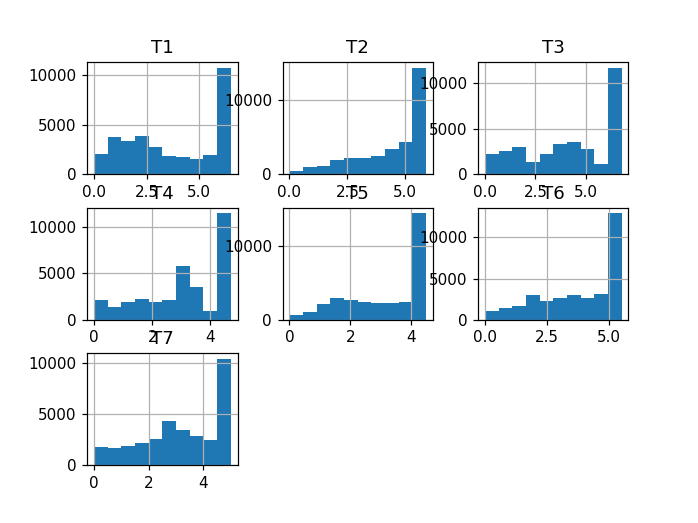

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f342d162a50>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f342d090f90>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f342d054650>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f342d008e50>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f342cfca690>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f342cffde90>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f3448303590>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f342e503d50>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f342e604690>]], dtype=object)

In [155]:
nn_input[('sys_states','tank_press')].hist()
#nn_input[('sys_inputs','head_pump_speed')].hist()
#nn_input[('sys_inputs','PRValve_dp')].hist()
#nn_input[('sys_inputs','TCValve_throttle')].hist()
#nn_input[('sys_inputs','jun_cl_demand_sum')].hist()


### Normalize Data:

In [156]:
input_offset = 0*nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = 0*nn_output.mean()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

### Train / Test Splitting

In [158]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [159]:
X_train.shape

(26827, 46)

# Neural Network

## Create Model

In [160]:
n_layer = 5
n_units = 50
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 46)]              0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                2350      
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_14 (Dense)             (None, 42)                2142      
Total params: 12,142
Trainable params: 12,142
Non-trainable params: 0
_______________________________________________________

## Train model

In [161]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [163]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=8000, 
                    epochs=2000,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),
                    callbacks=[callback])

Train on 26827 samples, validate on 6707 samples
Epoch 1/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0019 - val_loss: 0.0017
Epoch 2/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 3/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 4/2000
26827/26827 [==============================] - 0s 9us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 5/2000
26827/26827 [==============================] - 0s 9us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 6/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 7/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 8/2000
26827/26827 [==============================] - 0s 9us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 9/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.001

Epoch 76/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 77/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 78/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 79/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 80/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 81/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0018 - val_loss: 0.0017
Epoch 82/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 83/2000
26827/26827 [==============================] - 0s 9us/sample - loss: 0.0017 - val_loss: 0.0018
Epoch 84/2000
26827/26827 [==============================] - 0s 13us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 85/2000
2682

26827/26827 [==============================] - 0s 8us/sample - loss: 0.0018 - val_loss: 0.0017
Epoch 151/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 152/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 153/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 154/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 155/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0017 - val_loss: 0.0017
Epoch 156/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 157/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 158/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 159/2000
26827/2682

26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 225/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 226/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 227/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 228/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 229/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 230/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 231/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 232/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 233/2000
26827/2682

26827/26827 [==============================] - 0s 5us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 299/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 300/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 301/2000
26827/26827 [==============================] - 0s 5us/sample - loss: 0.0016 - val_loss: 0.0019
Epoch 302/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0018 - val_loss: 0.0017
Epoch 303/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 304/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 305/2000
26827/26827 [==============================] - 0s 12us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 306/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 307/2000
26827/268

26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 373/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 374/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 375/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 376/2000
26827/26827 [==============================] - 0s 5us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 377/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 378/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0017 - val_loss: 0.0019
Epoch 379/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 380/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 381/2000
26827/2682

26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 447/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 448/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 449/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0015
Epoch 450/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0018
Epoch 451/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0017 - val_loss: 0.0015
Epoch 452/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 453/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 454/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 455/2000
26827/2682

26827/26827 [==============================] - 0s 8us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 521/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 522/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 523/2000
26827/26827 [==============================] - 0s 9us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 524/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0015
Epoch 525/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 526/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 527/2000
26827/26827 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 528/2000
26827/26827 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 529/2000
26827/2682

26827/26827 [==============================] - 0s 8us/sample - loss: 0.0016 - val_loss: 0.0015
Epoch 595/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 596/2000
26827/26827 [==============================] - 0s 10us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 597/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 598/2000
26827/26827 [==============================] - 0s 9us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 599/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0016 - val_loss: 0.0015
Epoch 600/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 601/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 602/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 603/2000
26827/268

26827/26827 [==============================] - 0s 8us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 669/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 670/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 671/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 672/2000
26827/26827 [==============================] - 0s 11us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 673/2000
26827/26827 [==============================] - 0s 9us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 674/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 675/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 676/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 677/2000
26827/268

26827/26827 [==============================] - 0s 6us/sample - loss: 0.0016 - val_loss: 0.0015
Epoch 743/2000
26827/26827 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 744/2000
26827/26827 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 745/2000
26827/26827 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 746/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0015
Epoch 747/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 748/2000
26827/26827 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 749/2000
26827/26827 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 750/2000
26827/26827 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 751/2000
26827/2682

26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0015
Epoch 817/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0015
Epoch 818/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 819/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 820/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0016 - val_loss: 0.0015
Epoch 821/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 822/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 823/2000
26827/26827 [==============================] - 0s 5us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 824/2000
26827/26827 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 825/2000
26827/2682

26827/26827 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0014
Epoch 891/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 892/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0015 - val_loss: 0.0014
Epoch 893/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 894/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0015 - val_loss: 0.0017
Epoch 895/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0017 - val_loss: 0.0014
Epoch 896/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0016 - val_loss: 0.0017
Epoch 897/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 898/2000
26827/26827 [==============================] - 0s 9us/sample - loss: 0.0015 - val_loss: 0.0014
Epoch 899/2000
26827/2682

26827/26827 [==============================] - 0s 8us/sample - loss: 0.0015 - val_loss: 0.0014
Epoch 965/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 966/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 967/2000
26827/26827 [==============================] - 0s 8us/sample - loss: 0.0016 - val_loss: 0.0014
Epoch 968/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 969/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 970/2000
26827/26827 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 971/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 972/2000
26827/26827 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0014
Epoch 973/2000
26827/2682

26827/26827 [==============================] - 0s 8us/sample - loss: 0.0014 - val_loss: 0.0017
Epoch 1039/2000
26827/26827 [==============================] - 0s 5us/sample - loss: 0.0017 - val_loss: 0.0014
Epoch 1040/2000
26827/26827 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0016
Epoch 1041/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 1042/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1043/2000
26827/26827 [==============================] - 0s 5us/sample - loss: 0.0015 - val_loss: 0.0014
Epoch 1044/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 1045/2000
26827/26827 [==============================] - 0s 7us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 1046/2000
26827/26827 [==============================] - 0s 6us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 1047/2000
2

Save model:

In [173]:
model_path = './models/'
model_name = '006_man_5x50_both_datasets_filtered_mpc01'
model.save(model_path+model_name+'.h5')

train_data_param={
    'input_offset': input_offset,
    'input_scaling': input_scaling,
    'output_offset': output_offset,
    'output_scaling': output_scaling
}

with open(model_path+model_name+'_train_data_param.pkl','wb') as f:
    pickle.dump(train_data_param, f)

# Validation

In [165]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/Validation/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_val_list, nn_output_val_list = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, return_lists=True)

In [166]:
class simulator:
    def __init__(self, model, input_scaling, output_scaling, input_offset, output_offset, x0, t0):
        self.model = model
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.n_x = x0.shape[1]
        self.aux = []
                
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 3600
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate((self.x[[-1],:], self.u[[-1],:]),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
#         x_new = self.nn_out[:,:self.n_x]
        x_new = self.x[[-1],:]+self.nn_out[:,:self.n_x]
        aux_new = self.nn_out[:,self.n_x:]
        self.aux.append(aux_new)
    
        self.x = np.append(self.x, x_new, axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        if 'u' in self.__dict__:
            self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        else:
            self.u = sys_inputs_now.reshape(1,-1)
        
        self.eval_nn()

In [170]:
val_i = 0

sys_states = nn_input_val_list[val_i]['sys_states']
sys_inputs = nn_input_val_list[val_i]['sys_inputs']
sys_aux_outputs = nn_output_val_list[val_i]['aux_outputs']

x0 = sys_states.head(1).to_numpy()
t0 = 0

nsim = simulator(model, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [171]:
for k in range(10):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t.flatten())
sim_aux = pd.DataFrame(np.concatenate(nsim.aux), columns = sys_aux_outputs.columns,index=nsim.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


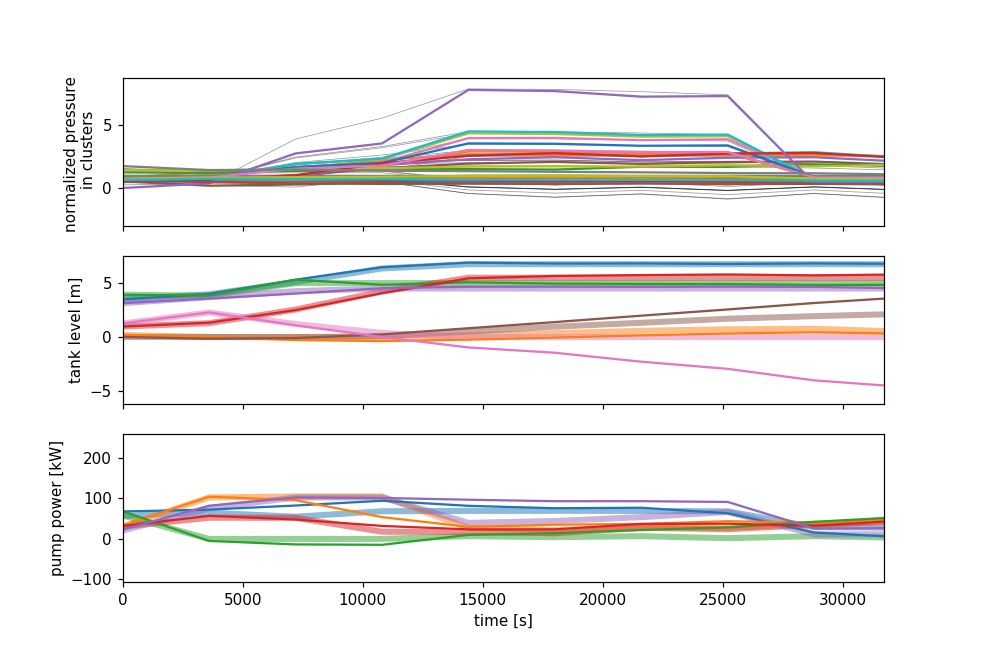

Text(0.5, 0, 'time [s]')

In [172]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,6))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')

# Linear Model

In [32]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [33]:
x0 = sys_states.head(1).to_numpy()
t0 = sys_states.head(1).index.to_numpy()

nsim_lin = simulator(linear_reg, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [34]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim_lin.next_step(sys_inputs_now)
sim_res_lin = pd.DataFrame(nsim_lin.x, columns=sys_states.columns, index=nsim_lin.t.flatten())
sim_aux_lin = pd.DataFrame(np.concatenate(nsim_lin.aux), columns = sys_aux_outputs.columns,index=nsim_lin.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


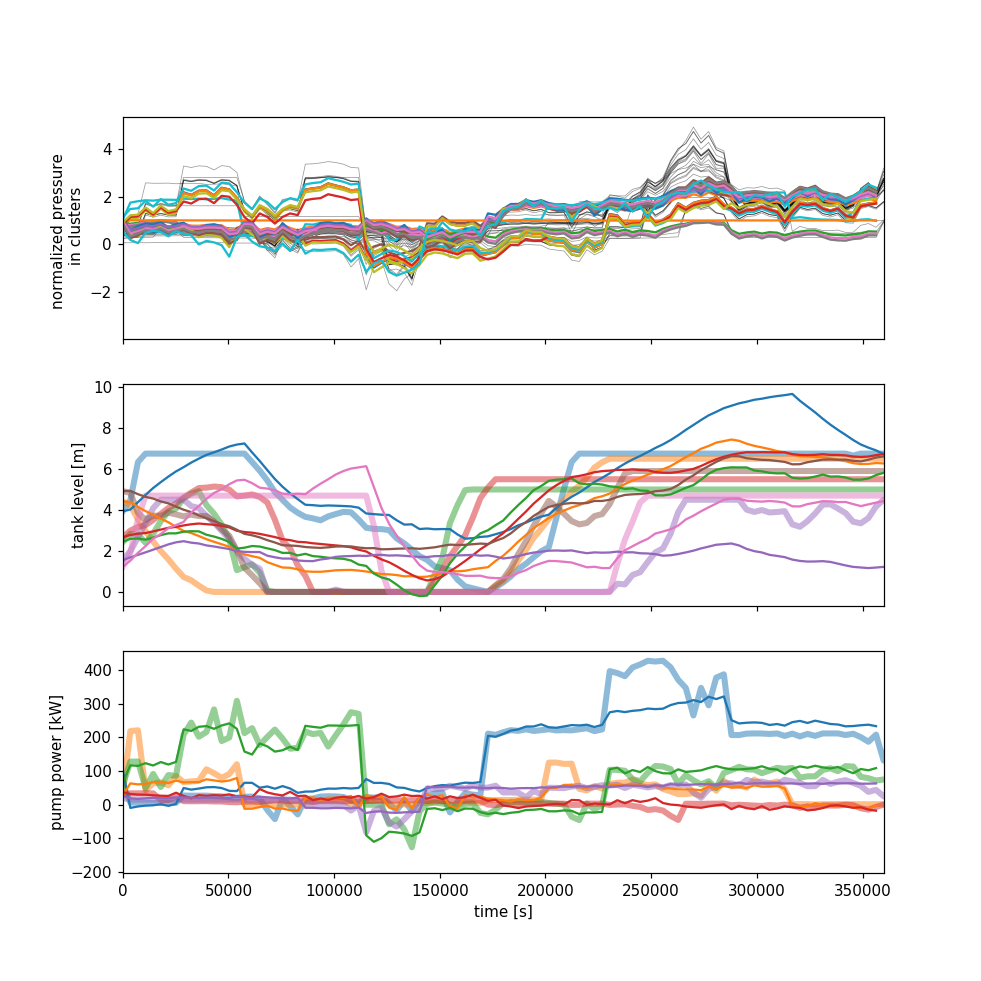

Text(0.5, 0, 'time [s]')

In [35]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,9))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux_lin['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res_lin['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux_lin['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res_lin.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')